# False positive and false negatives

> This notebook explores the two sources of systematic error that we identify and trim in our datasets.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## False positives

> False positives are defined as algorithms that, for a given gene, infer an outsized number of losses for that orthogroup.

> My programs output mean number of taxa that the algorithms inferred to have had lost the orthogroup, and variance of this number for each gene.

> It also identifies algorithms that have an outsize number of taxa (2 standard deviations above the mean). These are listed in the outlier column, if they were found.

In [2]:
stats2 = pd.read_csv("lossStats_HUMAN.csv",index_col=0)

In [3]:
stats2.fillna({"mean":np.nan,"variance":np.nan,"outliers":0},inplace=True)
stats2.head()

,mean,variance,outliers
Q8TEA1,28.538462,92.269231,0
A6NIH7,21.461538,25.769231,0
Q96HJ5,3.230769,18.192308,PANTHER8_all
O94913,7.076923,25.243590,Hieranoid_2
P37837,18.230769,47.858974,0


### Let's look at distribution of the mean and variance

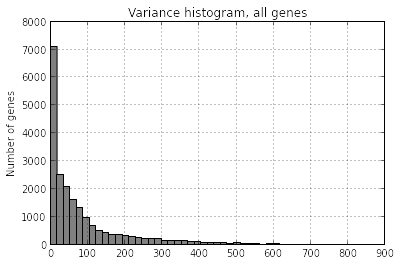

In [8]:
ax = stats2["variance"].hist(bins=50,color='grey')
ax.set_title("Variance histogram, all genes")
ax.set_ylabel("Number of genes")

#plt.savefig("variance_histogram.svg")

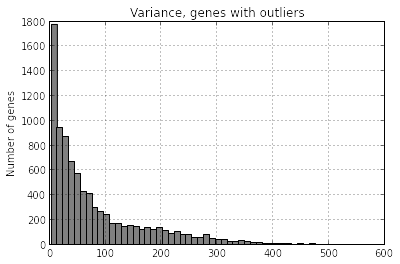

In [9]:
stats_outliers = stats2[stats2["outliers"] != 0]
ax = stats_outliers["variance"].hist(bins=50,color='grey')
ax.set_title("Variance, genes with outliers")
ax.set_ylabel("Number of genes")

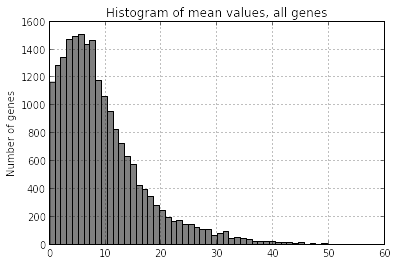

In [11]:
ax = stats2["mean"].hist(bins=50,color='grey')
ax.set_title("Histogram of mean values, all genes")
ax.set_ylabel("Number of genes")
#plt.savefig("mean_histogram.svg")

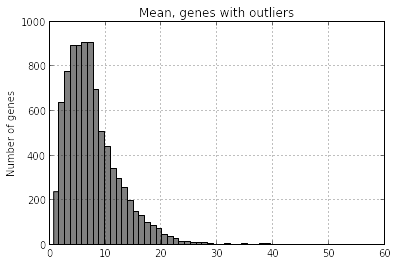

In [12]:
ax = stats_outliers["mean"].hist(bins=50,color='grey')
ax.set_title("Mean, genes with outliers")
ax.set_ylabel("Number of genes")

### Count number of outliers for each gene

In [13]:
stats2['numOutliers'] = stats2['outliers'].map(lambda x: len(x.split(" ")) if x != 0 else 0)
stats2.head()

,mean,variance,outliers,numOutliers
Q8TEA1,28.538462,92.269231,0,0
A6NIH7,21.461538,25.769231,0,0
Q96HJ5,3.230769,18.192308,PANTHER8_all,1
O94913,7.076923,25.243590,Hieranoid_2,1
P37837,18.230769,47.858974,0,0


In [14]:
stats2["numOutliers"].value_counts()

0    11774
1     7910
2      768
dtype: int64

### Get number of false positives (outliers) for each algorithm

In [15]:
FalsePos = pd.Series([db for row in stats2["outliers"] for db in str(row).split()]).value_counts()
FalsePos = FalsePos[FalsePos.index != '0'] # don't care about these
FalsePos

PANTHER8_all         2006
PhylomeDB            1805
Hieranoid_2          1309
EnsemblCompara_v2     971
Metaphors             810
RSD                   630
OMA_Pairs             529
OMA_Groups            439
EggNOG                224
PANTHER8_LDO          224
InParanoidCore        216
InParanoid            195
Orthoinspector         88
dtype: int64

## False Negatives

> False negatives are defined as oversplitting co-ortholog groups. See the paper for an in-depth description.

> My programs output a file that, for each gene, says whether or not each algorithm was found to oversplit.

In [16]:
ldos = pd.read_csv("HUMAN_LDO_results.csv",index_col=0)
ldos.head()

,OMA_Groups,PANTHER8_LDO,InParanoidCore,Orthoinspector,RSD,Hieranoid_2,OMA_Pairs,EnsemblCompara_v2,Metaphors,InParanoid,EggNOG,PANTHER8_all
A0A0A0MS98,False,False,False,False,True,False,False,False,False,False,NaN,NaN
A0A0A0MSL8,True,NaN,True,True,NaN,True,True,NaN,True,True,True,NaN
A0A0B4J1T7,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN
A0A0B4J1V8,False,NaN,False,NaN,NaN,NaN,True,NaN,NaN,False,NaN,NaN
A0A0B4J207,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get number of false negatives for each algorithm

In [18]:
FalseNeg = ldos.apply(pd.value_counts).ix[True]
FalseNeg.sort(ascending=False, inplace=True)
FalseNeg

PANTHER8_LDO         5692
RSD                  5628
OMA_Pairs            5032
OMA_Groups           4676
InParanoidCore       4496
Orthoinspector       4292
InParanoid           3462
EggNOG               3460
Hieranoid_2          2993
EnsemblCompara_v2    2766
Metaphors            1693
PANTHER8_all         1104
Name: True, dtype: int64

### Combine counts of false-negatives and false-positives for each algorithm

In [19]:
dbs = ["InParanoid","InParanoidCore","OMA_Groups","OMA_Pairs","PANTHER8_LDO","RSD","EggNOG","Orthoinspector",
       "Hieranoid_2","EnsemblCompara_v2","Metaphors","PhylomeDB","PANTHER8_all"]
errors = pd.DataFrame({"FalsePositive":FalsePos,"FalseNegative":FalseNeg})
errors = errors.reindex(dbs)
errors.head()

,FalseNegative,FalsePositive
InParanoid,3462,195
InParanoidCore,4496,216
OMA_Groups,4676,439
OMA_Pairs,5032,529
PANTHER8_LDO,5692,224


In [20]:
# errors.to_csv("errors_byDatabase.csv")

### Plot counts of errors for each algorithm

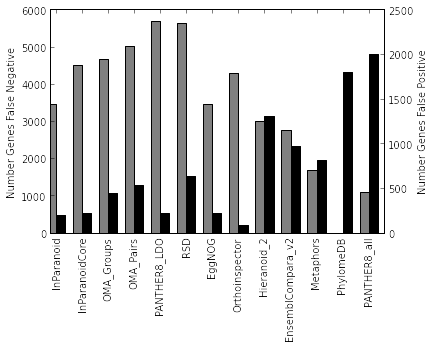

In [21]:
width = .35
fig, ax1 = plt.subplots()
errors["FalseNegative"].plot(kind='bar', ax=ax1, color='grey', width=width, position=1)
ax1.set_ylabel("Number Genes False Negative")

ax2 = ax1.twinx()
errors["FalsePositive"].plot(kind='bar', ax=ax2, color='black', width=width, position=0)
ax2.set_ylabel("Number Genes False Positive")

ax1.yaxis.grid(False)
ax2.yaxis.grid(False)
ax1.xaxis.grid(False)
ax2.xaxis.grid(False)

#plt.savefig("errors_byDatabase.svg")

## Proportional error by database

> Normalized error counts by database.

In [23]:
normErrors = errors/errors.sum()
normErrors["sumErrors"] = normErrors["FalseNegative"] + normErrors["FalsePositive"]
normErrors["normSum"] = normErrors["sumErrors"]/normErrors["sumErrors"].sum()
normErrors.sum()

FalseNegative    1.000000
FalsePositive    1.000000
sumErrors        1.808914
normSum          1.000000
dtype: float64

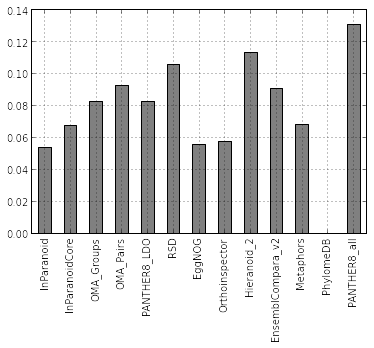

In [24]:
normErrors["normSum"].plot(kind='bar',color='grey')

#plt.savefig("totalErrors.svg")